In [5412]:
#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [5413]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import plotly.express as px
import lmfit as lm
%matplotlib inline

In [5414]:
# setting display option for pandas for columns
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [5415]:
response = requests.get('https://api.rootnet.in/covid19-in/stats/history')
covid_data = response.json()['data']
keys = ['day', 'total','discharged', 'deaths']

covid_india = pd.DataFrame([[d.get('day'), 
                                  d['summary'].get('total'), 
                                  d['summary'].get('discharged'), 
                                  d['summary'].get('deaths')] 
                                 for d in covid_data],
                    columns=keys)

In [5416]:
covid_india.head()

,day,total,discharged,deaths
0,2020-03-10,47,0,0
1,2020-03-11,60,0,0
2,2020-03-12,73,0,0
3,2020-03-13,82,10,2
4,2020-03-14,84,10,2


In [5417]:
covid_india.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   day         535 non-null    object
 1   total       535 non-null    int64 
 2   discharged  535 non-null    int64 
 3   deaths      535 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 16.8+ KB


In [5418]:
covid_india['Date'] = pd.to_datetime(covid_india['day'], infer_datetime_format=True)
covid_india.drop(columns='day',inplace=True)

In [5419]:
vaccine_data = pd.read_csv("vaccine_doses_statewise_v2.csv")
vaccine_data.head()

,Vaccinated As of,State,First Dose Administered,Second Dose Administered,Total Doses Administered
0,16/01/2021,Andaman and Nicobar Islands,225,0,225
1,16/01/2021,Andhra Pradesh,18412,0,18412
2,16/01/2021,Arunachal Pradesh,829,0,829
3,16/01/2021,Assam,3528,0,3528
4,16/01/2021,Bihar,18169,0,18169


In [5420]:
vaccine_data.rename(columns = {'Vaccinated As of':'Date'}, inplace=True)
#Converting date ibject type to datetime
vaccine_data.Date = pd.to_datetime(vaccine_data.Date, infer_datetime_format=True)
vaccine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      9120 non-null   datetime64[ns]
 1   State                     9120 non-null   object        
 2   First Dose Administered   9120 non-null   int64         
 3   Second Dose Administered  9120 non-null   int64         
 4   Total Doses Administered  9120 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 356.4+ KB


In [5421]:
vaccine_data.drop(columns=['First Dose Administered', 'Total Doses Administered'], inplace=True)
vaccine_data.head()

,Date,State,Second Dose Administered
0,2021-01-16,Andaman and Nicobar Islands,0
1,2021-01-16,Andhra Pradesh,0
2,2021-01-16,Arunachal Pradesh,0
3,2021-01-16,Assam,0
4,2021-01-16,Bihar,0


In [5422]:
vaccine_data_india = vaccine_data[vaccine_data.State == 'Total'].reset_index().drop(columns = 'index')

In [5423]:
covid_india_data = pd.merge(left= covid_india, right= vaccine_data_india, how='left', on = 'Date')

In [5424]:
covid_india_data['Second Dose Administered'] = pd.to_numeric(covid_india_data['Second Dose Administered'])

In [5425]:
fig = px.line(covid_india_data[(covid_india_data.Date >= '2021-03-01') & (covid_india_data.Date <='2021-05-31')], x='Date', y=['total', 'discharged', 'deaths', 'Second Dose Administered'])
fig.show()

In [5426]:
covid_india_data = covid_india_data[(covid_india_data.Date >= '2021-03-01') & (covid_india_data.Date <='2021-05-31')]

In [5427]:
covid_india_data.drop(columns=['State'], inplace=True)
covid_india_data.rename(columns = {'total':'Infected', 'discharged':'Recovered', 'deaths':'Deceased', 'Second Dose Administered':'Vaccinated'}, inplace=True)
covid_india_data.fillna(0, inplace=True)
covid_india_data.head()

,Infected,Recovered,Deceased,Date,Vaccinated
356,11112241,10786457,157157,2021-03-01,2597799.0
357,11124527,10798921,157248,2021-03-02,2713978.0
358,11139516,10812044,157346,2021-03-03,2876927.0
359,11156923,10826075,157435,2021-03-04,3208668.0
360,11173761,10839894,157548,2021-03-05,3501021.0


In [5428]:
covid_india_data[covid_india_data.Date == '2021-05-15']

,Infected,Recovered,Deceased,Date,Vaccinated
431,24372907,20432898,266207,2021-05-15,35857301.0


In [5429]:
covid_india_data.at[431, 'Vaccinated'] = (float(covid_india_data[covid_india_data.Date == '2021-05-14']['Vaccinated']) + float(covid_india_data[covid_india_data.Date == '2021-05-16']['Vaccinated']))/2 

In [5430]:
fig = px.line(covid_india_data[(covid_india_data.Date >= '2021-03-01') & (covid_india_data.Date <='2021-05-31')], x='Date', y=['Infected','Recovered','Deceased','Vaccinated'])
fig.show()

In [5431]:
covid_india_data.drop(columns='Date', inplace=True)

In [5432]:
covid_india_data = covid_india_data.reset_index().drop(columns='index')

def odesolver_SEIRD(t, initial_state, params):
    S0, E0, I0, R0, D0, V0 = initial_state
    beta  = params['beta0'].value
    gamma = params['gamma0'].value 
    sigma = params['sigma0'].value 
    mu = params['mu0'].value
    res = odeint(SEIRD, [S0, E0, I0, R0, D0], t, args = (beta, sigma, gamma, mu))
    return res

def residuals_SEIRD(params, t, state, data):
    expected = odesolver_SEIRD(t, state, params)
    observed = data
    return (expected[:,2:5] - observed).ravel()

In [5433]:
def SEIRDV(y, t, beta, sigma, gamma, nu, mu):
    S, E, I, R, D, V = y
    N = S + E + I + R + D + V
    dSdt = - beta * S * I / N -  nu * S
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    dVdt =  nu * S
    return dSdt, dEdt, dIdt, dRdt, dDdt, dVdt

In [5434]:
def odesolver_SEIRDV(t, intermediate_state, params):
    S1, E1, I1, R1, D1, V1 = intermediate_state
    beta  = params['beta'].value
    gamma = params['gamma'].value 
    sigma = params['sigma'].value 
    mu = params['mu'].value
    nu = params['nu'].value
    res = odeint(SEIRDV, [S1, E1, I1, R1, D1, V1], t, args = (beta, sigma, gamma, nu, mu))
    return res

In [5435]:
def residuals_SEIRDV(params, t, state, data):
    expected = odesolver_SEIRDV(t, state, params)
    observed = data
    return (expected[:,2:6] - observed).ravel()

In [5436]:
N = 1366400000
E0 = 100000
I0, R0 = 11112241, 10600625
D0 = 155550
V0 = 5000000
S0 = N - I0 - R0 - E0 - D0 - V0
initial_state = [S0, E0, I0, R0, D0, V0]

params = lm.Parameters()
params.add('beta', value=1.14, min=0, max=10)
params.add('gamma', value=0.02, min=0, max=10)
params.add('sigma', value=0.02, min=0, max=10)
params.add('mu', value=0.001, min=0, max=1)
params.add('nu', value=0.01, min=0, max=1)

In [5437]:
d = 92
tspan_train = np.arange(0,d,1)

data_india = covid_india_data.loc[0:d-1, :].values


In [5438]:
result1 = lm.minimize(residuals_SEIRDV, params, args = (tspan_train, initial_state, data_india), method = 'leastsq')
result1.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta    0.03639        0       10  0.00879     True     None     None
gamma  0.008043        0       10 0.0004434     True     None     None
mu     9.941e-05        0        1 0.0004108     True     None     None
nu     0.0002999        0        1 4.663e-06     True     None     None
sigma   0.03106        0       10  0.01352     True     None     None


In [5439]:
beta = result1.params['beta'].value
gamma = result1.params['gamma'].value
sigma = result1.params['sigma'].value
mu = result1.params['mu'].value
nu = result1.params['nu'].value

In [5440]:
tspan = np.arange(0,92,1)
ret = odeint(SEIRDV, [S0, E0, I0, R0, D0, V0], tspan, args = (beta, sigma, gamma, nu, mu))

In [5441]:
S, E, I, R, D, V = ret.T

In [5442]:
expected_data_india = pd.DataFrame({'Days':tspan,
                                'Susceptible':S,
                                'Exposed' : E,
                                'Infected':I,
                                'Recovered':R,
                                'Deceased':D})

In [5443]:
expected_data_india.head()

,Days,Susceptible,Exposed,Infected,Recovered,Deceased
0,0,1.339432e+09,1.000000e+05,1.111224e+07,1.060062e+07,155550.000000
1,1,1.338635e+09,4.856304e+05,1.103123e+07,1.068967e+07,156650.528042
2,2,1.337842e+09,8.566118e+05,1.096258e+07,1.077811e+07,157743.621988
3,3,1.337051e+09,1.213820e+06,1.090575e+07,1.086605e+07,158830.483290
4,4,1.336263e+09,1.558085e+06,1.086023e+07,1.095357e+07,159912.261291


In [5444]:
expected_data_india.shape

(92, 6)

In [5445]:
fig = px.line(expected_data_india, x='Days', y = ['Susceptible','Infected', 'Recovered', 'Deceased'])
fig.show()

In [5446]:
expected_data_india['Date'] = pd.date_range(start='2021-03-01', end='2021-05-31')
expected_data_india.drop(columns=['Days', 'Susceptible', 'Exposed'], inplace=True)
expected_data_india.rename(columns={'Infected':'e_Infected', 'Recovered':'e_Recovered', 'Deceased':'e_Deceased'}, inplace=True)
expected_data_india['e_Infected'] = expected_data_india['e_Infected'].astype('int32')
expected_data_india['e_Recovered'] = expected_data_india['e_Recovered'].astype('int32')
expected_data_india['e_Deceased'] = expected_data_india['e_Deceased'].astype('int32')
expected_data_india.head()

,e_Infected,e_Recovered,e_Deceased,Date
0,11112241,10600625,155550,2021-03-01
1,11031232,10689667,156650,2021-03-02
2,10962582,10778109,157743,2021-03-03
3,10905751,10866046,158830,2021-03-04
4,10860230,10953572,159912,2021-03-05


In [5447]:
observed_data_india = covid_india_data[['Infected','Recovered','Deceased']]
observed_data_india['Date'] = pd.date_range(start='2021-03-01', end='2021-05-31')
observed_data_india.rename(columns={'Infected':'o_Infected', 'Recovered':'o_Recovered', 'Deceased':'o_Deceased'}, inplace=True)
observed_data_india.head()

,o_Infected,o_Recovered,o_Deceased,Date
0,11112241,10786457,157157,2021-03-01
1,11124527,10798921,157248,2021-03-02
2,11139516,10812044,157346,2021-03-03
3,11156923,10826075,157435,2021-03-04
4,11173761,10839894,157548,2021-03-05


In [5448]:
eo_india = pd.merge(left=expected_data_india, right=observed_data_india, how='inner', on='Date')
eo_india.head()

,e_Infected,e_Recovered,e_Deceased,Date,o_Infected,o_Recovered,o_Deceased
0,11112241,10600625,155550,2021-03-01,11112241,10786457,157157
1,11031232,10689667,156650,2021-03-02,11124527,10798921,157248
2,10962582,10778109,157743,2021-03-03,11139516,10812044,157346
3,10905751,10866046,158830,2021-03-04,11156923,10826075,157435
4,10860230,10953572,159912,2021-03-05,11173761,10839894,157548


<Figure size 360x360 with 0 Axes>

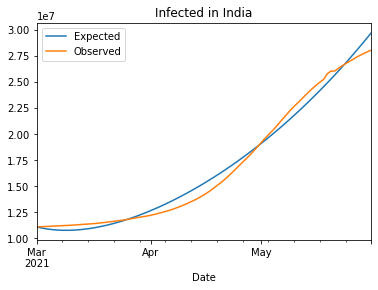

In [5449]:
plt.figure(figsize=(5,5))
eo_india.plot(x='Date', y = ['e_Infected', 'o_Infected'])
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.title('Infected in India')
plt.show()

<Figure size 360x360 with 0 Axes>

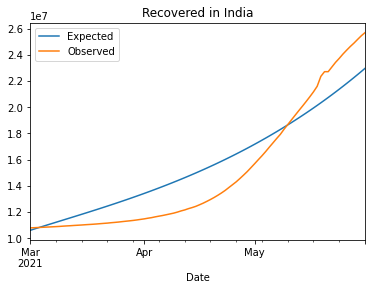

In [5450]:
plt.figure(figsize=(5,5))
eo_india.plot(x='Date', y = ['e_Recovered', 'o_Recovered'])
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.title('Recovered in India')
plt.show()

<Figure size 360x360 with 0 Axes>

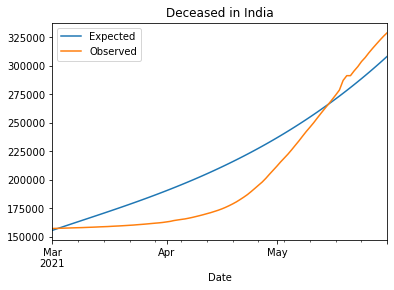

In [5451]:
plt.figure(figsize=(5,5))
eo_india.plot(x='Date', y = ['e_Deceased', 'o_Deceased'])
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.title('Deceased in India')
plt.show()

In [5452]:
daily_values_in = eo_india[['e_Infected', 'o_Infected', 'e_Recovered', 'o_Recovered', 'e_Deceased', 'o_Deceased']].diff().dropna()
daily_values_in = daily_values_in.reset_index().rename(columns = {'index':'days'})
daily_values_in.head(10)

,days,e_Infected,o_Infected,e_Recovered,o_Recovered,e_Deceased,o_Deceased
0,1,-81009.0,12286.0,89042.0,12464.0,1100.0,91.0
1,2,-68650.0,14989.0,88442.0,13123.0,1093.0,98.0
2,3,-56831.0,17407.0,87937.0,14031.0,1087.0,89.0
3,4,-45521.0,16838.0,87526.0,13819.0,1082.0,113.0
4,5,-34692.0,18327.0,87204.0,14234.0,1078.0,108.0
5,6,-24314.0,18711.0,86966.0,14392.0,1074.0,100.0
6,7,-14363.0,18599.0,86812.0,14278.0,1073.0,97.0
7,8,-4812.0,15388.0,86734.0,16596.0,1072.0,77.0
8,9,4358.0,17921.0,86733.0,20652.0,1072.0,133.0
9,10,13175.0,22854.0,86804.0,18100.0,1073.0,126.0


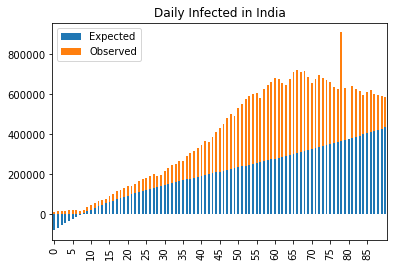

In [5481]:
daily_values_in[['e_Infected','o_Infected' ]].plot(kind = 'bar', stacked = True)
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.xticks(np.arange(0,90,5))
plt.title('Daily Infected in India')
plt.show()

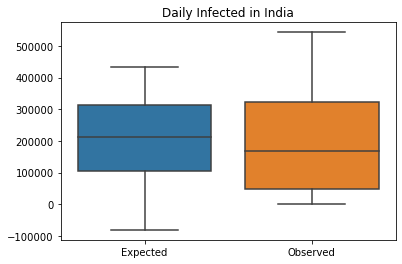

In [5480]:
sns.boxplot(data=daily_values_in[['e_Infected',	'o_Infected']])
plt.xticks([0,1],['Expected', 'Observed'])
plt.title('Daily Infected in India')
plt.show()

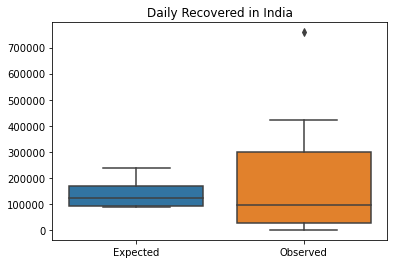

In [5479]:
sns.boxplot(data=daily_values_in[['e_Recovered','o_Recovered']])
plt.xticks([0,1],['Expected', 'Observed'])
plt.title('Daily Recovered in India')
plt.show()

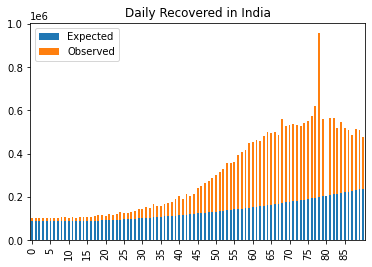

In [5477]:
daily_values_in[['e_Recovered','o_Recovered']].plot(kind = 'bar', stacked = True)
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.xticks(np.arange(0,90,5))
plt.title('Daily Recovered in India')
plt.show()

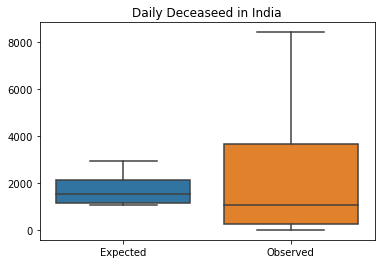

In [5478]:
sns.boxplot(data=daily_values_in[['e_Deceased',	'o_Deceased']])
plt.xticks([0,1],['Expected', 'Observed'])
plt.title('Daily Deceaseed in India')
plt.show()

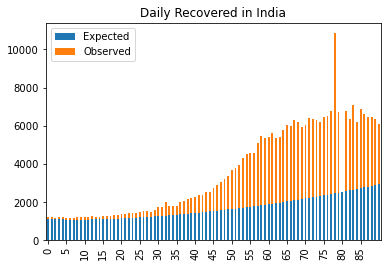

In [5475]:
daily_values_in[['e_Deceased',	'o_Deceased']].plot(kind = 'bar', stacked = True)
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.xticks(np.arange(0,90,5))
plt.title('Daily Recovered in India')
plt.show()

In [5283]:
global_data_infected = pd.read_csv("time_series_covid19_confirmed_global.csv")
global_data_infected.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [5284]:
global_data_recovered = pd.read_csv("time_series_covid19_recovered_global.csv")
global_data_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [5285]:
global_data_deceased = pd.read_csv("time_series_covid19_deaths_global.csv")
global_data_deceased.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/

In [5286]:
global_vaccine_data = pd.read_csv("owid-covid-data.csv")
global_vaccine_data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN


In [5287]:
global_data_infected.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
global_data_recovered.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
global_data_deceased.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)

In [5288]:
global_data_infected.columns[1:]

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '9/15/21', '9/16/21', '9/17/21', '9/18/21', '9/19/21', '9/20/21',
       '9/21/21', '9/22/21', '9/23/21', '9/24/21'],
      dtype='object', length=612)

In [5289]:
uk_infected_data = pd.melt(global_data_infected[global_data_infected['Country/Region'] == 'United Kingdom'], id_vars='Country/Region',
                           var_name='Date', value_name='Infected').drop(columns='Country/Region')
uk_recovered_data = pd.melt(global_data_recovered[global_data_recovered['Country/Region'] == 'United Kingdom'], id_vars='Country/Region',
                           var_name='Date', value_name='Recovered').drop(columns='Country/Region')
uk_deceased_data = pd.melt(global_data_deceased[global_data_deceased['Country/Region'] == 'United Kingdom'], id_vars='Country/Region',
                           var_name='Date', value_name='Deceased').drop(columns='Country/Region')

In [5290]:
uk_infected_data.head()

,Date,Infected
0,1/22/20,0
1,1/22/20,0
2,1/22/20,0
3,1/22/20,0
4,1/22/20,0


In [5291]:
uk_recovered_data.head()

,Date,Recovered
0,1/22/20,0
1,1/22/20,0
2,1/22/20,0
3,1/22/20,0
4,1/22/20,0


In [5292]:
uk_deceased_data.head()

,Date,Deceased
0,1/22/20,0
1,1/22/20,0
2,1/22/20,0
3,1/22/20,0
4,1/22/20,0


In [5293]:
uk_covid_data = pd.concat([uk_infected_data, uk_recovered_data['Recovered'], uk_deceased_data['Deceased']], axis=1)
uk_covid_data.head()

,Date,Infected,Recovered,Deceased
0,1/22/20,0,0,0
1,1/22/20,0,0,0
2,1/22/20,0,0,0
3,1/22/20,0,0,0
4,1/22/20,0,0,0


In [5294]:
uk_vaccine_data = global_vaccine_data[global_vaccine_data.location == 'United Kingdom']
uk_vaccine_data = uk_vaccine_data[['date', 'location','people_fully_vaccinated']]
uk_vaccine_data.dropna(axis=0, inplace=True)
uk_vaccine_data = uk_vaccine_data.iloc[:-2,:]
uk_vaccine_data.tail()

,date,location,people_fully_vaccinated
112996,2021-09-17,United Kingdom,44358523.0
112997,2021-09-18,United Kingdom,44430990.0
112998,2021-09-19,United Kingdom,44466121.0
112999,2021-09-20,United Kingdom,44512572.0
113000,2021-09-21,United Kingdom,44556005.0


In [5295]:
uk_vaccine_data = uk_vaccine_data.drop(columns='location').rename(columns={'people_fully_vaccinated' : 'Vaccinated', 'date':'Date'})

In [5296]:
uk_vaccine_data.head()

,Date,Vaccinated
112746,2021-01-10,391399.0
112747,2021-01-11,412167.0
112748,2021-01-12,428232.0
112749,2021-01-13,437977.0
112750,2021-01-14,443234.0


In [5297]:
uk_covid_data['Date'] = pd.to_datetime(uk_covid_data['Date'], infer_datetime_format=True)
uk_vaccine_data['Date'] = pd.to_datetime(uk_vaccine_data['Date'], infer_datetime_format=True)

In [5298]:
uk_covid_data = uk_covid_data.groupby(by='Date').sum().reset_index()
uk_covid_data.head()

,Date,Infected,Recovered,Deceased
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


In [5299]:
uk_covid_data = pd.merge(left = uk_covid_data, right= uk_vaccine_data, how='left', on='Date').fillna(0)

In [5300]:
uk_covid_data.head()

,Date,Infected,Recovered,Deceased,Vaccinated
0,2020-01-22,0,0,0,0.0
1,2020-01-23,0,0,0,0.0
2,2020-01-24,0,0,0,0.0
3,2020-01-25,0,0,0,0.0
4,2020-01-26,0,0,0,0.0


In [5301]:
fig = px.line(uk_covid_data[(uk_covid_data.Date >= '2021-03-01') & (uk_covid_data.Date <= '2021-05-31')], x = 'Date', y = ['Infected',	'Recovered',	'Deceased',	'Vaccinated'])
fig.show()

In [5302]:
uk_covid_data = uk_covid_data[(uk_covid_data.Date >= '2021-03-01') & (uk_covid_data.Date <= '2021-05-31')].reset_index().drop(columns=['index', 'Date'])
uk_covid_data.head()

,Infected,Recovered,Deceased,Vaccinated
0,4194289,11646,123187,844098.0
1,4200700,11662,123530,895412.0
2,4207120,11741,124017,963862.0
3,4213764,11795,124259,1034068.0
4,4219788,11834,124495,1090840.0


In [5303]:
uk_covid_data.shape

(92, 4)

In [5304]:
uk_covid_data[uk_covid_data.Vaccinated > 0].head()

,Infected,Recovered,Deceased,Vaccinated
0,4194289,11646,123187,844098.0
1,4200700,11662,123530,895412.0
2,4207120,11741,124017,963862.0
3,4213764,11795,124259,1034068.0
4,4219788,11834,124495,1090840.0


In [5305]:
N = 66000000
E0 = 3300000
I0, R0 = 4194289,11646	
D0 = 123187
V0 = 844098.0
S0 = N - I0 - R0 - E0 - D0 - V0
initial_state = [S0, E0, I0, R0, D0, V0]

params = lm.Parameters()
params.add('beta', value=1.14, min=0, max=10)
params.add('gamma', value=0.002, min=0, max=10)
params.add('sigma', value=0.02, min=0, max=10)
params.add('mu', value=0.01, min=0, max=1)
params.add('nu', value=0.01, min=0, max=1)

In [5306]:
d = 92
tspan_train = np.arange(0,d,1)

data_uk = uk_covid_data.loc[0:d-1, :].values

In [5307]:
result1 = lm.minimize(residuals_SEIRDV, params, args = (tspan_train, initial_state, data_uk), method = 'leastsq')
result1.params.pretty_print()

Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
beta   1.24e-09        0       10  0.01963     True     None     None
gamma  1.213e-05        0       10 0.0006509     True     None     None
mu     6.146e-05        0        1 0.0006499     True     None     None
nu     0.004701        0        1 9.402e-05     True     None     None
sigma  0.001329        0       10 0.001662     True     None     None


In [5308]:
beta = result1.params['beta'].value
gamma = result1.params['gamma'].value
sigma = result1.params['sigma'].value
mu = result1.params['mu'].value
nu = result1.params['nu'].value

In [5309]:
tspan = np.arange(0,92,1)
ret = odeint(SEIRDV, [S0, E0, I0, R0, D0, V0], tspan, args = (beta, sigma, gamma, nu, mu))

In [5310]:
S, E, I, R, D, V = ret.T

In [5311]:
expected_data_uk = pd.DataFrame({'Days':tspan,
                                'Susceptible':S,
                                'Exposed' : E,
                                'Infected':I,
                                'Recovered':R,
                                'Deceased':D})

In [5312]:
expected_data_uk.head()

,Days,Susceptible,Exposed,Infected,Recovered,Deceased
0,0,5.752678e+07,3.300000e+06,4.194289e+06,11646.000000,123187.000000
1,1,5.725695e+07,3.295617e+06,4.198363e+06,11696.888121,123444.920634
2,2,5.698839e+07,3.291240e+06,4.202432e+06,11747.825614,123703.091503
3,3,5.672109e+07,3.286868e+06,4.206494e+06,11798.812404,123961.512228
4,4,5.645505e+07,3.282502e+06,4.210550e+06,11849.848417,124220.182435


In [5313]:
expected_data_uk.shape

(92, 6)

In [5314]:
fig = px.line(expected_data_uk, x='Days', y = ['Infected','Recovered','Deceased'])
fig.show()

In [5315]:
expected_data_uk['Date'] = pd.date_range(start='2021-03-01', end='2021-05-31')
expected_data_uk.drop(columns=['Days', 'Susceptible', 'Exposed'], inplace=True)
expected_data_uk.rename(columns={'Infected':'e_Infected', 'Recovered':'e_Recovered', 'Deceased':'e_Deceased'}, inplace=True)
expected_data_uk['e_Infected'] = expected_data_uk['e_Infected'].astype('int32')
expected_data_uk['e_Recovered'] = expected_data_uk['e_Recovered'].astype('int32')
expected_data_uk['e_Deceased'] = expected_data_uk['e_Deceased'].astype('int32')
expected_data_uk.head()

,e_Infected,e_Recovered,e_Deceased,Date
0,4194289,11646,123187,2021-03-01
1,4198363,11696,123444,2021-03-02
2,4202431,11747,123703,2021-03-03
3,4206493,11798,123961,2021-03-04
4,4210549,11849,124220,2021-03-05


In [5316]:
observed_data_uk = uk_covid_data[['Infected','Recovered','Deceased']]
observed_data_uk['Date'] = pd.date_range(start='2021-03-01', end='2021-05-31')
observed_data_uk.rename(columns={'Infected':'o_Infected', 'Recovered':'o_Recovered', 'Deceased':'o_Deceased'}, inplace=True)
observed_data_uk.head()

,o_Infected,o_Recovered,o_Deceased,Date
0,4194289,11646,123187,2021-03-01
1,4200700,11662,123530,2021-03-02
2,4207120,11741,124017,2021-03-03
3,4213764,11795,124259,2021-03-04
4,4219788,11834,124495,2021-03-05


In [5317]:
eo_uk = pd.merge(left=expected_data_uk, right=observed_data_uk, how='inner', on='Date')
eo_uk.head()

,e_Infected,e_Recovered,e_Deceased,Date,o_Infected,o_Recovered,o_Deceased
0,4194289,11646,123187,2021-03-01,4194289,11646,123187
1,4198363,11696,123444,2021-03-02,4200700,11662,123530
2,4202431,11747,123703,2021-03-03,4207120,11741,124017
3,4206493,11798,123961,2021-03-04,4213764,11795,124259
4,4210549,11849,124220,2021-03-05,4219788,11834,124495


<Figure size 360x360 with 0 Axes>

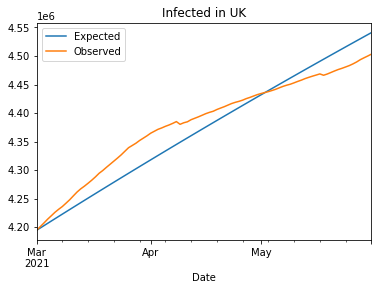

In [5318]:
plt.figure(figsize=(5,5))
eo_uk.plot(x='Date', y = ['e_Infected', 'o_Infected'])
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.title('Infected in UK')
plt.show()

<Figure size 360x360 with 0 Axes>

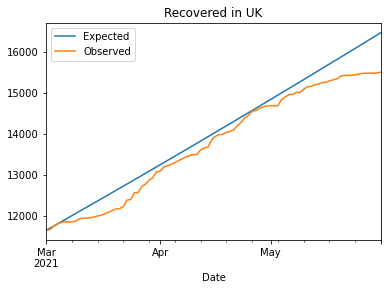

In [5319]:
plt.figure(figsize=(5,5))
eo_uk.plot(x='Date', y = ['e_Recovered', 'o_Recovered'])
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.title('Recovered in UK')
plt.show()

<Figure size 360x360 with 0 Axes>

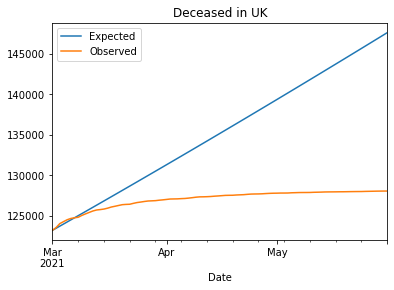

In [5320]:
plt.figure(figsize=(5,5))
eo_uk.plot(x='Date', y = ['e_Deceased', 'o_Deceased'])
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.title('Deceased in UK')
plt.show()

In [5454]:
daily_values_uk = eo_uk[['e_Infected', 'o_Infected', 'e_Recovered', 'o_Recovered', 'e_Deceased', 'o_Deceased']].diff().dropna()
daily_values_uk = daily_values_uk.reset_index().rename(columns = {'index':'days'})
daily_values_uk.head(10)

,days,e_Infected,o_Infected,e_Recovered,o_Recovered,e_Deceased,o_Deceased
0,1,4074.0,6411.0,50.0,16.0,257.0,343.0
1,2,4068.0,6420.0,51.0,79.0,259.0,487.0
2,3,4062.0,6644.0,51.0,54.0,258.0,242.0
3,4,4056.0,6024.0,51.0,39.0,259.0,236.0
4,5,4050.0,6118.0,51.0,15.0,259.0,159.0
5,6,4044.0,5260.0,52.0,2.0,259.0,82.0
6,7,4037.0,4823.0,51.0,2.0,259.0,65.0
7,8,4032.0,5869.0,51.0,15.0,260.0,231.0
8,9,4026.0,6021.0,51.0,55.0,260.0,190.0
9,10,4019.0,6835.0,52.0,21.0,260.0,181.0


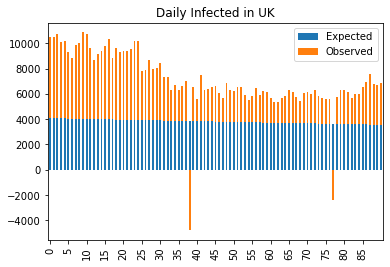

In [5484]:
daily_values_uk[['e_Infected','o_Infected' ]].plot(kind = 'bar', stacked = True)
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.xticks(np.arange(0,90,5))
plt.title('Daily Infected in UK')
plt.show()

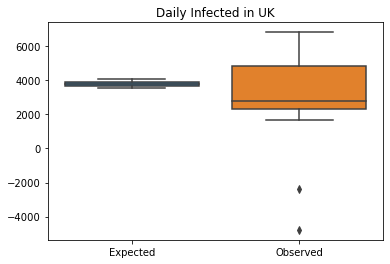

In [5485]:
sns.boxplot(data=daily_values_uk[['e_Infected',	'o_Infected']])
plt.xticks([0,1],['Expected', 'Observed'])
plt.title('Daily Infected in UK')
plt.show()

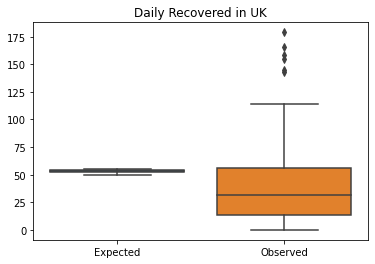

In [5486]:
sns.boxplot(data=daily_values_uk[['e_Recovered','o_Recovered']])
plt.xticks([0,1],['Expected', 'Observed'])
plt.title('Daily Recovered in UK')
plt.show()

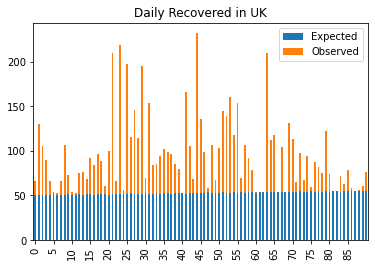

In [5487]:
daily_values_uk[['e_Recovered','o_Recovered']].plot(kind = 'bar', stacked = True)
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.xticks(np.arange(0,90,5))
plt.title('Daily Recovered in UK')
plt.show()

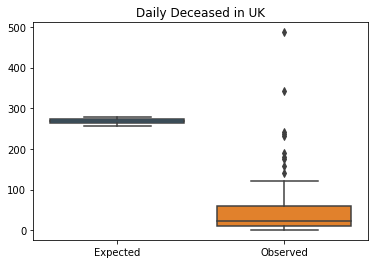

In [5488]:
sns.boxplot(data=daily_values_uk[['e_Deceased',	'o_Deceased']])
plt.xticks([0,1],['Expected', 'Observed'])
plt.title('Daily Deceased in UK')
plt.show()

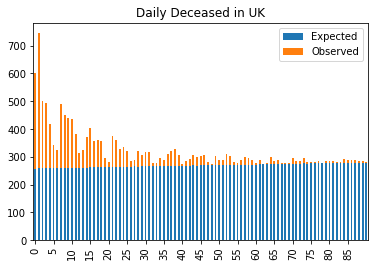

In [5489]:
daily_values_uk[['e_Deceased',	'o_Deceased']].plot(kind = 'bar', stacked = True)
L = plt.legend()
L.get_texts()[0].set_text('Expected')
L.get_texts()[1].set_text('Observed')
plt.xticks(np.arange(0,90,5))
plt.title('Daily Deceased in UK')
plt.show()